# Photokinetic Simulator

This notebook allows you to create a compartmental models from simple text-based input. The system of ordinary differential equations (ODEs) can be displayed and steady state approximation for transient species can be performed symbolically. Symbolic manipulations are performed with [Sympy](https://www.sympy.org/en/index.html) module. The compartmental model can be simulated for different input parameters and initial concentrations.

### Rules for the Input Text Model

Expected format of the text-based input is single or multiline, forward reactions and absorptions are denoted with `-->` and `-hv->` signs, respecively. Names of compartments are case sensitive. It is possible to denote the sub- and/or superscript with $\LaTeX$ notation (for details, see the corresponding [tutorial](https://cs.overleaf.com/learn/latex/Mathematical_expressions)):

* `^1S` $\rightarrow$ $\mathrm{^1S}$ 
* `^1O_2`  $\rightarrow$   $\mathrm{^1O_2}$
*  `RB^{\bullet 3-}` $\rightarrow$   $\mathrm{RB^{\bullet 3-}}$

Names of the rate constants for individual reactions can be taken from the text input. They can be denoted at the end of the each line after `//` characters and are separated by semicolon `;`. It means, that semicolon cannot appear in the name of the rate constant (this could be improved in the future). If the rate constant name is not specified, default name using the reactants and products will be used. Comments are denoted by `#`. All characters after this symbol will be ignored. The rate constants can be specified in $\LaTeX$ notation:

* `k_r` $\rightarrow$ $k_r$ 
* `k_{isc}` $\rightarrow$ $k_{isc}$
* `k_d^{\prime}` $\rightarrow$ $k_d^{\prime}$

*Note: The backslash in the $\LaTeX$ notation (e.g. \prime, \bullet) have to be escaped in the text model (see later).*

### Simulation of the Model

The rate constants and intial concentrations has to be supplied in the order they are stored in the model. To see the correct order, print the following attributes of the instantiated model:

* `symbols['rate_constants']`
* `symbols['compartments']`

In the case of photoreactions, the symbol $J$ is the "concentration of photons" that hits the sample. Usual unit would be $[J] = \mathrm{mol\ s^{-1}\ L^{-1}}$:

$$J = \frac{q_0}{V}$$

Here, $q_0$ is the incident photon flux and $V$ is the volume of the sample in the cuvette. For the usage of the symbolic model, see the examples below.

In [5]:
#@title Install and Load Packages { display-mode: "form" }

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left to download and import the required packages 
#@markdown in this Colab notebook.

#@markdown **Note**: This installs the sympy package on the Colab 
#@markdown notebook in the cloud and not on your computer.

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import sympy
except ImportError:
    %shell pip install sympy

from sympy import symbols, Symbol
from IPython.display import display, Math
import matplotlib.pyplot as plt

# set font size and ticks widths of matplotlib figures
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'xtick.major.size': 5, 'ytick.major.size': 5})
plt.rcParams.update({'xtick.minor.size': 2.5, 'ytick.minor.size': 2.5})
plt.rcParams.update({'xtick.major.width': 1, 'ytick.major.width': 1})
plt.rcParams.update({'xtick.minor.width': 0.8, 'ytick.minor.width': 0.8})

import numpy as np

try:
    import kin_model
except ImportError:
    %shell wget -q "https://raw.githubusercontent.com/dmadea/Photo-Kinetic-Simulator/main/kin_model.py"

from kin_model import PhotoKineticSymbolicModel

In [6]:
#@title Fontsize of the Output Cells { display-mode: "form", run: "auto" }

#@markdown Set the fontsize of the text in output cells,
#@markdown default value is 18px.

#@markdown **Note**: In order for the change to have an effect
#@markdown you have to rerun the cells.

font_size =   18#@param {type:"integer"}

# from https://stackoverflow.com/questions/61957742/how-to-increase-font-size-of-google-colab-cell-output
def increase_font():
    from IPython.display import Javascript
    display(Javascript(f'''
    for (rule of document.styleSheets[0].cssRules){{
        if (rule.selectorText=='body') {{
            rule.style.fontSize = '{font_size}px'
            break
        }}
    }}'''))

if IN_COLAB:
    # set it to run in every cell
    get_ipython().events.register('pre_run_cell', increase_font)
    # disable
    # get_ipython().events.unregister('pre_run_cell', increase_font)

### Simple Sequential Kinetic Model

In the following example, the simulation of simple sequential model is shown. The individual operations are explained by the code comments.

In [7]:
# define a sequential kinetic model
text_model = """
A --> B --> C --> D 
"""

# instantiate the model
model = PhotoKineticSymbolicModel.from_text(text_model)
model.print_model()  # print the model
model.pprint_equations()  # print the ODEs

<IPython.core.display.Math object>

Eq(Derivative(c_{A}(t), t), -k_{AB}*c_{A}(t))

Eq(Derivative(c_{B}(t), t), k_{AB}*c_{A}(t) - k_{BC}*c_{B}(t))

Eq(Derivative(c_{C}(t), t), k_{BC}*c_{B}(t) - k_{CD}*c_{C}(t))

Eq(Derivative(c_{D}(t), t), k_{CD}*c_{C}(t))

[k_{AB}, k_{BC}, k_{CD}] [c_{A}(t), c_{B}(t), c_{C}(t), c_{D}(t)]


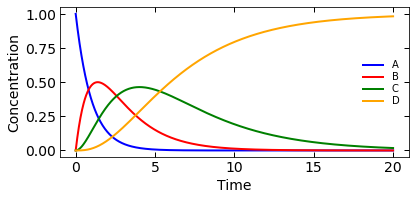

In [8]:
# print the order of rate constants and the compartment names in which they appear in the model
print(model.symbols['rate_constants'], model.symbols['compartments'])

# set the input parameters
rate_constants = [ 1, 0.5, 0.25 ]  # in the order of k_{AB}, k_{BC}, k_{CD}
initial_concentrations = [ 1, 0, 0, 0 ] # in the order of A, B, C, D

# simulate the model, t_max is the last time point of the simulation
model.simulate_model(rate_constants, initial_concentrations, t_max=20, plot_separately=False)

### Simple Photokinetic Model

In the following example, the ground state of a compound absorbs the light and forms a singlet state. It mainly decays back to the ground state, but some will lead to photoreaction to form a product. The purpose is to simulate the time profile of the ground state. Because singlet state lifetime is much shorter than the time changes of the overall steady state reaction, we will make the steady state approximation for the singlet state.

In [9]:
text_model = """
GS -hv-> ^1S --> GS  // k_s  # absorption and decay back to ground state
^1S --> P            // k_r  # formation of the photoproduct from the singlet state
"""

# instantiate the model
model = PhotoKineticSymbolicModel.from_text(text_model)
model.print_model()  # print the model
model.pprint_equations()  # print the ODEs

# perform the steady state approximation for singlet state
model.steady_state_approx(['^1S'])

<IPython.core.display.Math object>

Eq(Derivative(c_{GS}(t), t), -J*(1 - 1/10**(epsilon*l*c_{GS}(t))) + k_s*c_{^1S}(t))

Eq(Derivative(c_{^1S}(t), t), J*(1 - 1/10**(epsilon*l*c_{GS}(t))) - k_r*c_{^1S}(t) - k_s*c_{^1S}(t))

Eq(Derivative(c_{P}(t), t), k_r*c_{^1S}(t))

Eq(Derivative(c_{GS}(t), t), -J*k_r*(10**(epsilon*l*c_{GS}(t)) - 1)/(10**(epsilon*l*c_{GS}(t))*(k_r + k_s)))

Eq(c_{^1S}(t), J*(10**(epsilon*l*c_{GS}(t)) - 1)/(10**(epsilon*l*c_{GS}(t))*(k_r + k_s)))

Eq(Derivative(c_{P}(t), t), J*k_r*(10**(epsilon*l*c_{GS}(t)) - 1)/(10**(epsilon*l*c_{GS}(t))*(k_r + k_s)))

[k_s, k_r] [c_{GS}(t), c_{^1S}(t), c_{P}(t)]


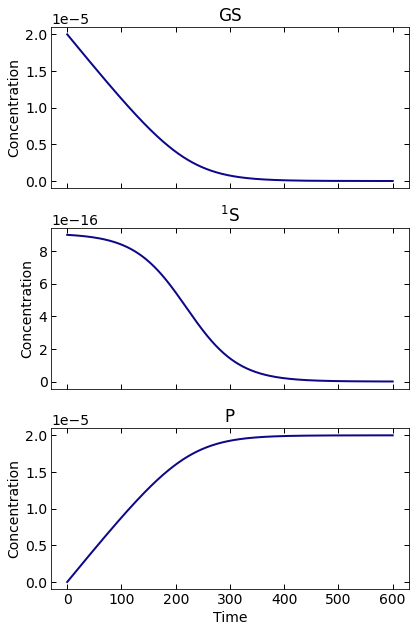

In [10]:
# print the order of rate constants and the compartment names in which they appear in the model
print(model.symbols['rate_constants'], model.symbols['compartments'])

# set the input parameters
rate_constants = [ 1e9, 1e8 ]  # in the order of k_s, k_r
initial_concentrations = [ 2e-5, 0, 0 ] # in the order of GS, ^1S, P

# simulate the model, flux is the 'concentration of photons', it is the J parameter
# l is the length of the cuvette = 1 and epsilon = 1e5 is molar abs. coefficient
# as we start with c=2e-5, the initial absorbance A = 2
model.simulate_model(rate_constants, initial_concentrations, t_max=600, flux=1e-6, l=1, epsilon=1e5, plot_separately=True)

### SIR Epidemic Model

In the following example, the SIR model for epidemic is simulated.

In [11]:
str_model = """
Susceptible + Infected --> 2Infected // k_t   # transmission rate
Infected --> Recovered               // k_r   # recovery rate
Infected --> Dead                    // k_d   # death rate
"""

# instantiate the model
model = PhotoKineticSymbolicModel.from_text(str_model)

model.print_model()
model.pprint_equations()

<IPython.core.display.Math object>

Eq(Derivative(c_{Susceptible}(t), t), -k_t*c_{Infected}(t)*c_{Susceptible}(t))

Eq(Derivative(c_{Infected}(t), t), -k_d*c_{Infected}(t) - k_r*c_{Infected}(t) + k_t*c_{Infected}(t)*c_{Susceptible}(t))

Eq(Derivative(c_{Recovered}(t), t), k_r*c_{Infected}(t))

Eq(Derivative(c_{Dead}(t), t), k_d*c_{Infected}(t))

[k_t, k_r, k_d] [c_{Susceptible}(t), c_{Infected}(t), c_{Recovered}(t), c_{Dead}(t)]


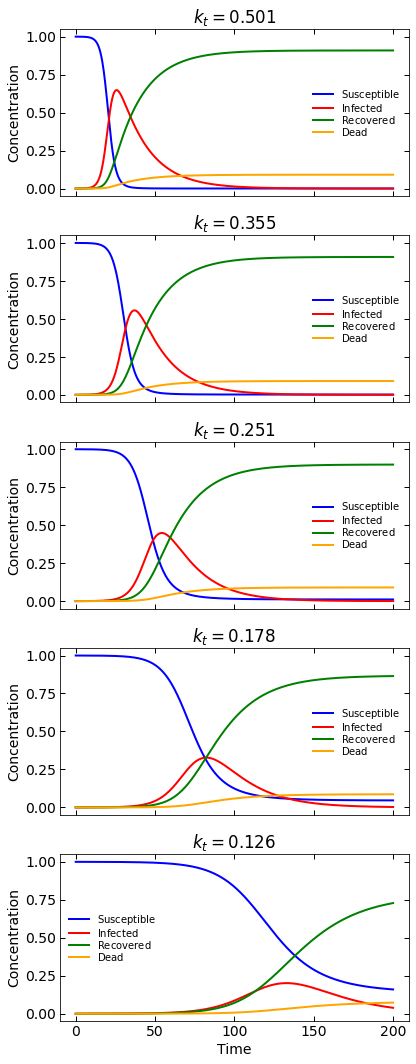

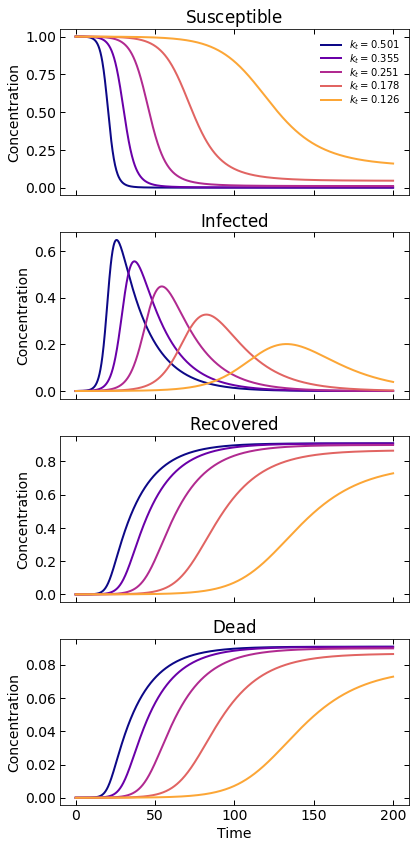

In [12]:
# print the order of rate constants and the compartment names in which they appear in the model
print(model.symbols['rate_constants'], model.symbols['compartments'])

# set the input parameters, use a range of transmission rate constants
rate_constants = [ np.logspace(-0.3, -0.9, 5), 0.05, 0.005 ]  # in the order of k_t, k_r, k_d
initial_concentrations = [ 1, 1e-4, 0, 0 ] # in the order of Ssusceptible, Infected, Recovered, Dead

# simulate the model, the model will simulated 5 times for 5 different transmission rates
# that were set in the rate_constants variable
model.simulate_model(rate_constants, initial_concentrations, t_max=2e2, plot_separately=False)
model.simulate_model(rate_constants, initial_concentrations, t_max=2e2, plot_separately=True)  # plot separately the same model

### Transient Kinetics of Rose Bengal

In the following example, the transient kinetics of Rose Bengal under degassed conditions will be simulated. The kinetic model is based on our [publication](https://pubs.rsc.org/en/content/articlelanding/2016/cp/c6cp01710j#!divAbstract). The rate data for MeCN were used. Because the singlet state lifetime is much shorter that those of a triplet and radical pairs, we will make a steady state approximation for the singlet state. We need to include the singlet state to the model due to its formation by triplet-triplet annihilation process of two triplets.

In [13]:
# escape the backslash characters
str_model = """
^1RB^{2-*} --> RB^{2-}                                        // k_s  # singlet decay to ground state
^1RB^{2-*} --> ^3RB^{2-*} --> RB^{2-}                         // k_{isc} ; k_d
^3RB^{2-*} + RB^{2-} --> 2RB^{2-}                             // k_{sq}
^3RB^{2-*} + RB^{2-} --> RB^{\\bullet -} + RB^{\\bullet 3-}   // k_{redox*}
2^3RB^{2-*} --> ^1RB^{2-*}  + ^3RB^{2-*}                      // k_{TT}  # triplet-triplet annihilation
2^3RB^{2-*} --> RB^{\\bullet -}  + RB^{\\bullet 3-}           // k_{redox**}
RB^{\\bullet -}  + RB^{\\bullet 3-} --> 2 RB^{2-}             // k_{-eT}  # back electron transfer
"""

# instantiate the model
model = PhotoKineticSymbolicModel.from_text(str_model)

model.print_model()
model.pprint_equations()

<IPython.core.display.Math object>

Eq(Derivative(c_{^1RB^{2-*}}(t), t), -k_s*c_{^1RB^{2-*}}(t) + k_{TT}*c_{^3RB^{2-*}}(t)**2 - k_{isc}*c_{^1RB^{2-*}}(t))

Eq(Derivative(c_{RB^{2-}}(t), t), k_d*c_{^3RB^{2-*}}(t) + k_s*c_{^1RB^{2-*}}(t) + 2*k_{-eT}*c_{RB^{\bullet-}}(t)*c_{RB^{\bullet3-}}(t) - k_{redox*}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t) + k_{sq}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t))

Eq(Derivative(c_{^3RB^{2-*}}(t), t), -k_d*c_{^3RB^{2-*}}(t) - k_{TT}*c_{^3RB^{2-*}}(t)**2 + k_{isc}*c_{^1RB^{2-*}}(t) - 2*k_{redox**}*c_{^3RB^{2-*}}(t)**2 - k_{redox*}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t) - k_{sq}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t))

Eq(Derivative(c_{RB^{\bullet-}}(t), t), -k_{-eT}*c_{RB^{\bullet-}}(t)*c_{RB^{\bullet3-}}(t) + k_{redox**}*c_{^3RB^{2-*}}(t)**2 + k_{redox*}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t))

Eq(Derivative(c_{RB^{\bullet3-}}(t), t), -k_{-eT}*c_{RB^{\bullet-}}(t)*c_{RB^{\bullet3-}}(t) + k_{redox**}*c_{^3RB^{2-*}}(t)**2 + k_{redox*}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t))

In [14]:
# make a steady state approximation for the singlet state
model.steady_state_approx(['^1RB^{2-*}'])

Eq(c_{^1RB^{2-*}}(t), k_{TT}*c_{^3RB^{2-*}}(t)**2/(k_s + k_{isc}))

Eq(Derivative(c_{RB^{2-}}(t), t), -(-k_d*k_s*c_{^3RB^{2-*}}(t) - k_d*k_{isc}*c_{^3RB^{2-*}}(t) - 2*k_s*k_{-eT}*c_{RB^{\bullet-}}(t)*c_{RB^{\bullet3-}}(t) - k_s*k_{TT}*c_{^3RB^{2-*}}(t)**2 + k_s*k_{redox*}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t) - k_s*k_{sq}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t) - 2*k_{-eT}*k_{isc}*c_{RB^{\bullet-}}(t)*c_{RB^{\bullet3-}}(t) + k_{isc}*k_{redox*}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t) - k_{isc}*k_{sq}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t))/(k_s + k_{isc}))

Eq(Derivative(c_{^3RB^{2-*}}(t), t), -(k_d*k_s + k_d*k_{isc} + k_s*k_{TT}*c_{^3RB^{2-*}}(t) + 2*k_s*k_{redox**}*c_{^3RB^{2-*}}(t) + k_s*k_{redox*}*c_{RB^{2-}}(t) + k_s*k_{sq}*c_{RB^{2-}}(t) + 2*k_{isc}*k_{redox**}*c_{^3RB^{2-*}}(t) + k_{isc}*k_{redox*}*c_{RB^{2-}}(t) + k_{isc}*k_{sq}*c_{RB^{2-}}(t))*c_{^3RB^{2-*}}(t)/(k_s + k_{isc}))

Eq(Derivative(c_{RB^{\bullet-}}(t), t), -k_{-eT}*c_{RB^{\bullet-}}(t)*c_{RB^{\bullet3-}}(t) + k_{redox**}*c_{^3RB^{2-*}}(t)**2 + k_{redox*}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t))

Eq(Derivative(c_{RB^{\bullet3-}}(t), t), -k_{-eT}*c_{RB^{\bullet-}}(t)*c_{RB^{\bullet3-}}(t) + k_{redox**}*c_{^3RB^{2-*}}(t)**2 + k_{redox*}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t))

Rate constants: [k_s, k_{isc}, k_d, k_{sq}, k_{redox*}, k_{TT}, k_{redox**}, k_{-eT}]
Compartments: [c_{^1RB^{2-*}}(t), c_{RB^{2-}}(t), c_{^3RB^{2-*}}(t), c_{RB^{\bullet-}}(t), c_{RB^{\bullet3-}}(t)]


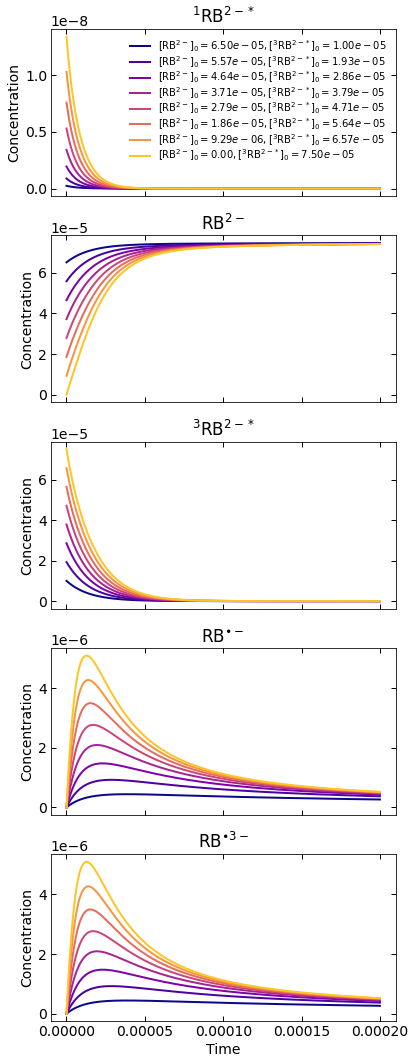

In [15]:
# print the order of rate constants and the compartment names in which they appear in the model
print('Rate constants:', model.symbols['rate_constants'])
print('Compartments:', model.symbols['compartments'])

# parameters in MeCN, taken from https://pubs.rsc.org/en/content/articlelanding/2016/cp/c6cp01710j#!divAbstract
fl_lifetime = 2380e-12  # fluorescence lifetime
k_s_tot = 1/fl_lifetime  # total decay rate of the singlet state
k_isc = 2.77e8  # rate of intersystem crossing
phi_isc = k_isc / k_s_tot  # intersystem crossing quantum yield
k_s_GS = (1 - phi_isc) * k_s_tot  # decay rate of singlet state to ground state

rate_constants = [ k_s_GS, k_isc, 1.01e4, 7.63e8, 3.89e7, 9.98e8, 1.86e8, 1.03e10]

c_tot = 75e-6  # total concentration of RB
c_triplet = np.linspace(10e-6, c_tot, 8)  # various concentrations of triplet
c_GS = c_tot - c_triplet
initial_concentrations = [ 0, c_GS, c_triplet, 0, 0 ]

# simulate the model, the model will simulated 8 times for 8 different GS and triplet
# initial concentrations, total concentration of RB is kept constant
model.simulate_model(rate_constants, initial_concentrations, t_max=2e-4, plot_separately=True)

### Decomposition of Endoperoxide

Here, the decomposition of aryl endoperoxide is shown. It produces singlet oxygen which can be traped with some substrate S. Singlet oxygen in solution has quite short lifetime and also, it can be physically quenched by all species contained in a solution. This is simulated in the following example.

In [18]:
str_model = """
ArO_2 --> Ar + ^1O_2                 // k_1  # production of singlet oxygen
^1O_2 --> ^3O_2                      // k_d  # decay rate of singlet oxygen through solvent
^1O_2 + Ar --> Ar + ^3O_2            // k_{q,Ar}     # quenching of singlet ox. by naphthalene
^1O_2 + ArO_2 --> ArO_2 + ^3O_2      // k_{q,ArO_2}  # quenching of singlet ox. by endoperoxide
^1O_2 + S --> S + ^3O_2              // k_{q}  # quenching of singlet ox. by substrate
S + ^1O_2 -->                        // k_r    # reaction of substrate with singlet ox.
"""

model = PhotoKineticSymbolicModel.from_text(str_model)

model.print_model()
model.steady_state_approx(['^1O_2'])  # make SS approximation for singlet oxygen

<IPython.core.display.Math object>

Eq(Derivative(c_{ArO_2}(t), t), -k_1*c_{ArO_2}(t))

Eq(Derivative(c_{Ar}(t), t), k_1*c_{ArO_2}(t))

Eq(c_{^1O_2}(t), k_1*c_{ArO_2}(t)/(k_d + k_r*c_{S}(t) + k_{q,ArO_2}*c_{ArO_2}(t) + k_{q,Ar}*c_{Ar}(t) + k_{q}*c_{S}(t)))

Eq(Derivative(c_{^3O_2}(t), t), k_1*(k_d + k_{q,ArO_2}*c_{ArO_2}(t) + k_{q,Ar}*c_{Ar}(t) + k_{q}*c_{S}(t))*c_{ArO_2}(t)/(k_d + k_r*c_{S}(t) + k_{q,ArO_2}*c_{ArO_2}(t) + k_{q,Ar}*c_{Ar}(t) + k_{q}*c_{S}(t)))

Eq(Derivative(c_{S}(t), t), -k_1*k_r*c_{ArO_2}(t)*c_{S}(t)/(k_d + k_r*c_{S}(t) + k_{q,ArO_2}*c_{ArO_2}(t) + k_{q,Ar}*c_{Ar}(t) + k_{q}*c_{S}(t)))

Rate constants: [k_1, k_d, k_{q,Ar}, k_{q,ArO_2}, k_{q}, k_r]
Compartments: [c_{ArO_2}(t), c_{Ar}(t), c_{^1O_2}(t), c_{^3O_2}(t), c_{S}(t)]


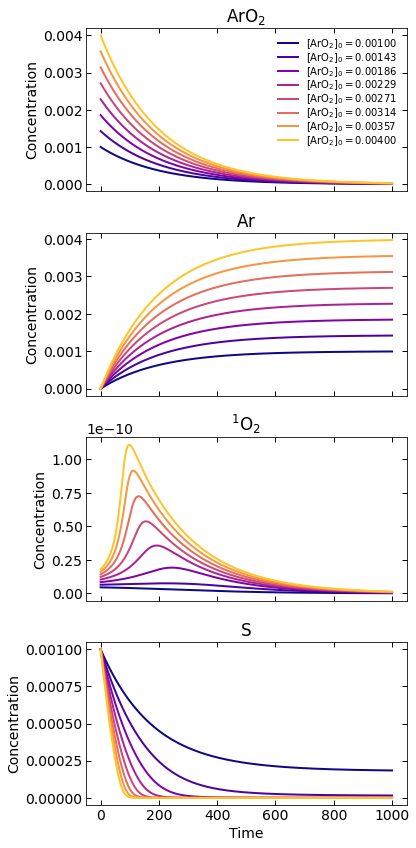

In [24]:
# print the order of rate constants and the compartment names in which they appear in the model
print('Rate constants:', model.symbols['rate_constants'])
print('Compartments:', model.symbols['compartments'])

# set the input parameters, use a range of transmission rate constants
rate_constants = [ 5e-3, 1/9.5e-6, 1e4, 1e4, 1e4, 1e9 ] 
initial_concentrations = [np.linspace(1e-3, 4e-3, 8), 0, 0, 0, 1e-3 ]

model.simulate_model(rate_constants, initial_concentrations,
                     constant_compartments=['^3O_2'], t_max=1e3, plot_separately=True)

### Self-sensitized Degradation of a Sensitizer

Sensitizer produces singlet oxygen by TT annihilation. Singlet oxygen then slowly destroys the photosensitizer. The rate laws are generated in the following example.

In [25]:
str_model = """
PS -hv-> ^1PS --> PS          // k_s  # population of singlet state and decay to GS with
^1PS --> ^3PS --> PS          // k_{isc} ; k_T
^3PS + ^3O_2 --> ^1O_2 + PS   // k_{TT}
^1O_2 --> ^3O_2               // k_d
^1O_2 + PS --> PS + ^3O_2     // k_q
PS + ^1O_2 -->                // k_r
"""

model = PhotoKineticSymbolicModel.from_text(str_model)

model.print_model()
# make steady state approximation for singlet, triplet and singlet oxygen
model.steady_state_approx(['^1PS', '^3PS', '^1O_2'])  

<IPython.core.display.Math object>

Eq(Derivative(c_{PS}(t), t), -J*k_r*k_{TT}*k_{isc}*(10**(epsilon*l*c_{PS}(t)) - 1)*c_{PS}(t)*c_{^3O_2}(t)/(10**(epsilon*l*c_{PS}(t))*(k_T + k_{TT}*c_{^3O_2}(t))*(k_s + k_{isc})*(k_d + k_q*c_{PS}(t) + k_r*c_{PS}(t))))

Eq(c_{^1PS}(t), J*(10**(epsilon*l*c_{PS}(t)) - 1)/(10**(epsilon*l*c_{PS}(t))*(k_s + k_{isc})))

Eq(c_{^3PS}(t), J*k_{isc}*(10**(epsilon*l*c_{PS}(t)) - 1)/(10**(epsilon*l*c_{PS}(t))*(k_T + k_{TT}*c_{^3O_2}(t))*(k_s + k_{isc})))

Eq(Derivative(c_{^3O_2}(t), t), -J*k_r*k_{TT}*k_{isc}*(10**(epsilon*l*c_{PS}(t)) - 1)*c_{PS}(t)*c_{^3O_2}(t)/(10**(epsilon*l*c_{PS}(t))*(k_T + k_{TT}*c_{^3O_2}(t))*(k_s + k_{isc})*(k_d + k_q*c_{PS}(t) + k_r*c_{PS}(t))))

Eq(c_{^1O_2}(t), J*k_{TT}*k_{isc}*(10**(epsilon*l*c_{PS}(t)) - 1)*c_{^3O_2}(t)/(10**(epsilon*l*c_{PS}(t))*(k_T + k_{TT}*c_{^3O_2}(t))*(k_s + k_{isc})*(k_d + k_q*c_{PS}(t) + k_r*c_{PS}(t))))